# Which one is a better plan?

You work as an analyst for the telecom operator Megaline. The company offers its clients two prepaid plans, Surf and Ultimate. The commercial department wants to know which of the plans brings in more revenue in order to adjust the advertising budget.

You are going to carry out a preliminary analysis of the plans based on a relatively small client selection. You'll have the data on 500 Megaline clients: who the clients are, where they're from, which plan they use, and the number of calls they made and text messages they sent in 2018. Your job is to analyze the clients' behavior and determine which prepaid plan brings in more revenue.

## Initialization

Load all the libraries, that could be usefull for the investigation 

In [1]:
# Loading all the libraries
import pandas as pd
import numpy as np
import datetime as dt
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce
from scipy import stats as st

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

## Load data

Load 5 data dataframes from Megaline

In [2]:
# Load the data files into different DataFrames
calls=pd.read_csv('/datasets/megaline_calls.csv')
internet=pd.read_csv('/datasets/megaline_internet.csv')
sms=pd.read_csv('/datasets/megaline_messages.csv')
plans=pd.read_csv('/datasets/megaline_plans.csv')
users=pd.read_csv('/datasets/megaline_users.csv')


## Prepare the data

Let's explore each one of the dataframes to get an initial understanding of the data and correct to each table if necessary.

## Plans

In [3]:
# Print the general/summary information about the plans' DataFrame

plans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


In [4]:
# Print a sample of data for plans
plans.head()


,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


In [5]:
plans.isnull().sum()

messages_included        0
mb_per_month_included    0
minutes_included         0
usd_monthly_pay          0
usd_per_gb               0
usd_per_message          0
usd_per_minute           0
plan_name                0
dtype: int64

I don't see any inappropriate data types or missing data etc.

In [6]:
#Creating the column `gb_per_month_inclueded`
plans['mb_per_month_included'] = plans['mb_per_month_included']/1024
plans = plans.rename(columns = {'mb_per_month_included':'gb_per_month_included'})

#Check the table
plans


,messages_included,gb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15.0,500,20,10,0.03,0.03,surf
1,1000,30.0,3000,70,7,0.01,0.01,ultimate


## Users

In [7]:
# Print the general/summary information about the users' DataFrame
users.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [8]:
# Print a sample of data for users
users.head()


,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN


We see in the data sample some issues: inappropriate data types in reg_date, missing data in churn_date and it should be fixed.

 Fix Data

In [9]:
#Changing types of `reg_date` and `chunk_date` to date time 
users['reg_date'] = pd.to_datetime(users['reg_date'], format = '%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users[users['churn_date'].notnull()]['churn_date'], format ='%Y-%m-%d')

#Replacing missing values
users.fillna('None', inplace=True)

#Splitting the `city` column and creating the `region` column
users[['city', 'region']]=users['city'].str.split(',', expand = True)
#Check if it works
users.info()
type(users.loc[6, 'churn_date'])
users.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan        500 non-null    object        
 7   churn_date  500 non-null    object        
 8   region      500 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(6)
memory usage: 35.3+ KB


pandas._libs.tslibs.timestamps.Timestamp

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,region
0,1000,Anamaria,Bauer,45,Atlanta-Sandy Springs-Roswell,2018-12-24,ultimate,None,GA MSA
1,1001,Mickey,Wilkerson,28,Seattle-Tacoma-Bellevue,2018-08-13,surf,None,WA MSA
2,1002,Carlee,Hoffman,36,Las Vegas-Henderson-Paradise,2018-10-21,surf,None,NV MSA
3,1003,Reynaldo,Jenkins,52,Tulsa,2018-01-28,surf,None,OK MSA
4,1004,Leonila,Thompson,40,Seattle-Tacoma-Bellevue,2018-05-23,surf,None,WA MSA
5,1005,Livia,Shields,31,Dallas-Fort Worth-Arlington,2018-11-29,surf,None,TX MSA
6,1006,Jesusa,Bradford,73,San Francisco-Oakland-Berkeley,2018-11-27,ultimate,2018-12-18 00:00:00,CA MSA
7,1007,Eusebio,Welch,42,Grand Rapids-Kentwood,2018-07-11,surf,None,MI MSA
8,1008,Emely,Hoffman,53,Orlando-Kissimmee-Sanford,2018-08-03,ultimate,None,FL MSA
9,1009,Gerry,Little,19,San Jose-Sunnyvale-Santa Clara,2018-04-22,surf,None,CA MSA


We have successfully changed types of reg_date and churn_date cilumns. We have also replaced the missing values. We checked that all date values have appropriate type in churn_date column as there are also string values, the rype of the whole column is object, but types of the values where we have a date value is datetime. And finaly we created the region column for future analtsis. Everything is OK.

## Calls

In [10]:
# Print the general/summary information about the calls' DataFrame
calls.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [11]:
# Print a sample of data for calls
calls.head()


,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22


We should change data type for call_date that may need in further investigation.

### Fix data

In [12]:
#Changing type of the `call_date` column
calls['call_date']=pd.to_datetime(calls['call_date'], format='%Y-%m-%d')

#Round up `duration` column
calls['duration'] = np.ceil(calls['duration']).astype(int)

#Check everuthing is fine
calls.info()
calls.head(5)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  object        
 1   user_id    137735 non-null  int64         
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 4.2+ MB


,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,9
1,1000_145,1000,2018-12-27,14
2,1000_247,1000,2018-12-27,15
3,1000_309,1000,2018-12-28,6
4,1000_380,1000,2018-12-30,5


### Enrich data

Adding additional columns month and year for the future analysis.

In [13]:
#Adding year and month columns
calls['year'] = calls['call_date'].dt.year
calls['month'] = calls['call_date'].dt.month

#Checking that everything is good
calls.head(10)

calls['year'].unique()
calls['month'].unique()



,id,user_id,call_date,duration,year,month
0,1000_93,1000,2018-12-27,9,2018,12
1,1000_145,1000,2018-12-27,14,2018,12
2,1000_247,1000,2018-12-27,15,2018,12
3,1000_309,1000,2018-12-28,6,2018,12
4,1000_380,1000,2018-12-30,5,2018,12
5,1000_388,1000,2018-12-31,3,2018,12
6,1000_510,1000,2018-12-27,6,2018,12
7,1000_521,1000,2018-12-28,15,2018,12
8,1000_530,1000,2018-12-28,6,2018,12
9,1000_544,1000,2018-12-26,5,2018,12


array([2018])

array([12,  9, 10, 11,  8,  7,  6,  5,  3,  4,  2,  1])

## Messages

In [14]:
# Print the general/summary information about the messages' DataFrame

sms.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [15]:
# Print a sample of data for messages
sms.head()


,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26


We see in the printed data sample an inappropriate data type in message_date.

### Fix data

In [16]:
#Changing type of the `message_date` column
sms['message_date']=pd.to_datetime(sms['message_date'], format='%Y-%m-%d')

#Check everuthing is fine
sms.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.7+ MB


### Enrich data

Adding additional columns month and year for the future analysis.

In [17]:
#Adding year and month columns
sms['year'] = sms['message_date'].dt.year
sms['month'] = sms['message_date'].dt.month

#Checking that everything is good
sms.head(10)

sms['year'].unique()
sms['month'].unique()


,id,user_id,message_date,year,month
0,1000_125,1000,2018-12-27,2018,12
1,1000_160,1000,2018-12-31,2018,12
2,1000_223,1000,2018-12-31,2018,12
3,1000_251,1000,2018-12-27,2018,12
4,1000_255,1000,2018-12-26,2018,12
5,1000_346,1000,2018-12-29,2018,12
6,1000_386,1000,2018-12-30,2018,12
7,1000_413,1000,2018-12-31,2018,12
8,1000_502,1000,2018-12-27,2018,12
9,1000_525,1000,2018-12-28,2018,12


array([2018])

array([12, 11,  8, 10,  9,  6,  7,  5,  4,  3,  2,  1])

## Internet

In [18]:
# Print the general/summary information about the internet DataFrame
internet.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [19]:
# Print a sample of data for the internet traffic
internet.head()



,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22


We see in the general information an issue (inappropriate data type in session_date).

### Fix data

In [20]:
#Changing type of the `session_date` column
internet['session_date']=pd.to_datetime(internet['session_date'], format='%Y-%m-%d')

#Check everuthing is fine
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  int64         
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 3.2+ MB


### Enrich data

Adding additional columns month and year for the future analysis.

In [21]:
#Adding year and month columns
internet['year'] = internet['session_date'].dt.year
internet['month'] = internet['session_date'].dt.month

#Checking that everything is good
internet.head(10)

internet['year'].unique()
internet['month'].unique()

,id,user_id,session_date,mb_used,year,month
0,1000_13,1000,2018-12-29,89.86,2018,12
1,1000_204,1000,2018-12-31,0.00,2018,12
2,1000_379,1000,2018-12-28,660.40,2018,12
3,1000_413,1000,2018-12-26,270.99,2018,12
4,1000_442,1000,2018-12-27,880.22,2018,12
5,1001_0,1001,2018-08-24,284.68,2018,8
6,1001_3,1001,2018-12-09,656.04,2018,12
7,1001_4,1001,2018-11-04,16.97,2018,11
8,1001_10,1001,2018-11-27,135.18,2018,11
9,1001_15,1001,2018-12-13,761.92,2018,12


array([2018])

array([12,  8, 11, 10,  9,  7,  6,  5,  3,  4,  2,  1])

## Study plan conditions

It is critical to understand how the plans work, how users are charged based on their plan subscription. So, we suggest printing out the plan information to view their conditions once again.

In [22]:
# Print out the plan conditions and make sure they are clear for you

plans

,messages_included,gb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15.0,500,20,10,0.03,0.03,surf
1,1000,30.0,3000,70,7,0.01,0.01,ultimate


## Aggregate data per user

Now aggregating data per user per month in order to have just one record per user per period. 

In [23]:
# Calculate the number of calls made by each user per month. Save the result.
calls_num = calls.groupby(['user_id', 'month'])['duration'].count().reset_index()
calls_num


,user_id,month,duration
0,1000,12,16
1,1001,8,27
2,1001,9,49
3,1001,10,65
4,1001,11,64
...,...,...,...
2253,1498,12,39
2254,1499,9,41
2255,1499,10,53
2256,1499,11,45


In [24]:
# Calculate the amount of minutes spent by each user per month. Save the result.
calls_minutes = calls.groupby(['user_id', 'month'])['duration'].sum().reset_index()

#Renaming column `duration` to `calls_dur`
calls_minutes.rename(columns = {'duration':'calls_dur'}, inplace=True)
calls_minutes

,user_id,month,calls_dur
0,1000,12,124
1,1001,8,182
2,1001,9,315
3,1001,10,393
4,1001,11,426
...,...,...,...
2253,1498,12,339
2254,1499,9,346
2255,1499,10,385
2256,1499,11,308


In [25]:
# Calculate the number of messages sent by each user per month. Save the result.
messages_sum = sms.groupby(['user_id', 'month'])['id'].count().reset_index()

#Renaming the column `id` to `messages`
messages_sum.rename(columns = {'id':'messages'}, inplace = True)
messages_sum

,user_id,month,messages
0,1000,12,11
1,1001,8,30
2,1001,9,44
3,1001,10,53
4,1001,11,36
...,...,...,...
1801,1496,9,21
1802,1496,10,18
1803,1496,11,13
1804,1496,12,11


In [26]:
# Calculate the volume of internet traffic used by each user per month. Save the result.
internet_sum = internet.groupby(['user_id', 'month'])['mb_used'].sum().reset_index()
internet_sum

,user_id,month,mb_used
0,1000,12,1901.47
1,1001,8,6919.15
2,1001,9,13314.82
3,1001,10,22330.49
4,1001,11,18504.30
...,...,...,...
2272,1498,12,23137.69
2273,1499,9,12984.76
2274,1499,10,19492.43
2275,1499,11,16813.83


Now put the aggregate data together into one DataFrame, so that one row would represent what an unique user consumed Gb in a given month.

In [27]:
# Merge the data for calls duration, messages, internet based on user_id and month
data_frames = [calls_minutes, messages_sum, internet_sum]
data = reduce(lambda left, right: pd.merge(left, right, on = ['user_id', 'month'], how = 'outer'), data_frames)
data.info()
data.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2293 entries, 0 to 2292
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   user_id    2293 non-null   int64  
 1   month      2293 non-null   int64  
 2   calls_dur  2258 non-null   float64
 3   messages   1806 non-null   float64
 4   mb_used    2277 non-null   float64
dtypes: float64(3), int64(2)
memory usage: 107.5 KB


,user_id,month,calls_dur,messages,mb_used
0,1000,12,124.0,11.0,1901.47
1,1001,8,182.0,30.0,6919.15
2,1001,9,315.0,44.0,13314.82
3,1001,10,393.0,53.0,22330.49
4,1001,11,426.0,36.0,18504.30
5,1001,12,412.0,44.0,19369.18
6,1002,10,59.0,15.0,6552.01
7,1002,11,386.0,32.0,19345.08
8,1002,12,384.0,41.0,14396.24
9,1003,12,1104.0,50.0,27044.14


In [28]:
#Replacing missing values
data.fillna(0, inplace=True)

#Creating `gb_used` column
data['gb_used'] = np.ceil(data['mb_used']/1024).astype(int)
data.info()
data.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2293 entries, 0 to 2292
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   user_id    2293 non-null   int64  
 1   month      2293 non-null   int64  
 2   calls_dur  2293 non-null   float64
 3   messages   2293 non-null   float64
 4   mb_used    2293 non-null   float64
 5   gb_used    2293 non-null   int64  
dtypes: float64(3), int64(3)
memory usage: 125.4 KB


,user_id,month,calls_dur,messages,mb_used,gb_used
0,1000,12,124.0,11.0,1901.47,2
1,1001,8,182.0,30.0,6919.15,7
2,1001,9,315.0,44.0,13314.82,14
3,1001,10,393.0,53.0,22330.49,22
4,1001,11,426.0,36.0,18504.30,19
5,1001,12,412.0,44.0,19369.18,19
6,1002,10,59.0,15.0,6552.01,7
7,1002,11,386.0,32.0,19345.08,19
8,1002,12,384.0,41.0,14396.24,15
9,1003,12,1104.0,50.0,27044.14,27


In [29]:
# Add the plan information
data['plan_name'] = data.user_id.map(users.set_index('user_id')['plan'])

#Add region information
data['region'] = data.user_id.map(users.set_index('user_id')['region'])
data


,user_id,month,calls_dur,messages,mb_used,gb_used,plan_name,region
0,1000,12,124.0,11.0,1901.47,2,ultimate,GA MSA
1,1001,8,182.0,30.0,6919.15,7,surf,WA MSA
2,1001,9,315.0,44.0,13314.82,14,surf,WA MSA
3,1001,10,393.0,53.0,22330.49,22,surf,WA MSA
4,1001,11,426.0,36.0,18504.30,19,surf,WA MSA
...,...,...,...,...,...,...,...,...
2288,1349,12,0.0,61.0,13039.91,13,surf,MA-NH MSA
2289,1361,5,0.0,2.0,1519.69,2,surf,AL MSA
2290,1482,10,0.0,2.0,0.00,0,ultimate,NY-NJ-PA MSA
2291,1108,12,0.0,0.0,233.17,1,ultimate,UT MSA


Calculating the monthly revenue from each user with a function.

In [30]:
#Calculating the monthly revenue through the function
# Calculate the monthly revenue for additional minutes
def revenue(row):
    tarriff = row['plan_name']
    month_pay = plans[plans['plan_name']==tarriff]['usd_monthly_pay'].iloc[0]

#Calcilating additional call pay    
    minutes = row['calls_dur']
    minutes_inc = plans[plans['plan_name']==tarriff]['minutes_included'].iloc[0]
    minutes_fee = plans[plans['plan_name']==tarriff]['usd_per_minute'].iloc[0]
        
    minutes_add = minutes - minutes_inc
    if minutes_add <0:
        minutes_cost = 0
    else:
        minutes_cost = minutes_add * minutes_fee
    
#Calcilating additional message pay    
    messages = row['messages']
    messages_inc = plans[plans['plan_name']==tarriff]['messages_included'].iloc[0]
    messages_fee = plans[plans['plan_name']==tarriff]['usd_per_message'].iloc[0]
        
    messages_add = messages - messages_inc
    if messages_add <0:
        messages_cost = 0
    else:
        messages_cost = messages_add * messages_fee

#Calcilating additional internet pay    
    internet = row['gb_used']
    internet_inc = plans[plans['plan_name']==tarriff]['gb_per_month_included'].iloc[0]
    internet_fee = plans[plans['plan_name']==tarriff]['usd_per_gb'].iloc[0]
        
    internet_add = internet - internet_inc
    if internet_add <0:
        internet_cost = 0
    else:
        internet_cost = internet_add * internet_fee    
    
#Calculating total cost per month    
    cost  = minutes_cost + messages_cost + internet_cost + month_pay
    return cost

#Applying the fuction in order to calculate monthly revenue
data['revenue_month'] = data.apply(revenue, axis = 1)





In [31]:
# print the dataframe with column monthly revenue for each user
data.head(10)

,user_id,month,calls_dur,messages,mb_used,gb_used,plan_name,region,revenue_month
0,1000,12,124.0,11.0,1901.47,2,ultimate,GA MSA,70.00
1,1001,8,182.0,30.0,6919.15,7,surf,WA MSA,20.00
2,1001,9,315.0,44.0,13314.82,14,surf,WA MSA,20.00
3,1001,10,393.0,53.0,22330.49,22,surf,WA MSA,90.09
4,1001,11,426.0,36.0,18504.30,19,surf,WA MSA,60.00
5,1001,12,412.0,44.0,19369.18,19,surf,WA MSA,60.00
6,1002,10,59.0,15.0,6552.01,7,surf,NV MSA,20.00
7,1002,11,386.0,32.0,19345.08,19,surf,NV MSA,60.00
8,1002,12,384.0,41.0,14396.24,15,surf,NV MSA,20.00
9,1003,12,1104.0,50.0,27044.14,27,surf,OK MSA,158.12


## Study user behaviour

Calculate some useful descriptive statistics for the aggregated and merged data, which typically reveal an overall picture captured by the data. Draw useful plots to help the understanding. The main task is to compare the plans and decide on which one is more profitable, the statistics and the plots will be calculated on a per-plan basis.

### Calls

<AxesSubplot:xlabel='month'>

Text(0.5, 1.0, 'Comparision of the calls duration per month')

Text(0, 0.5, 'Min')

Text(0.5, 0, 'Calls duration')

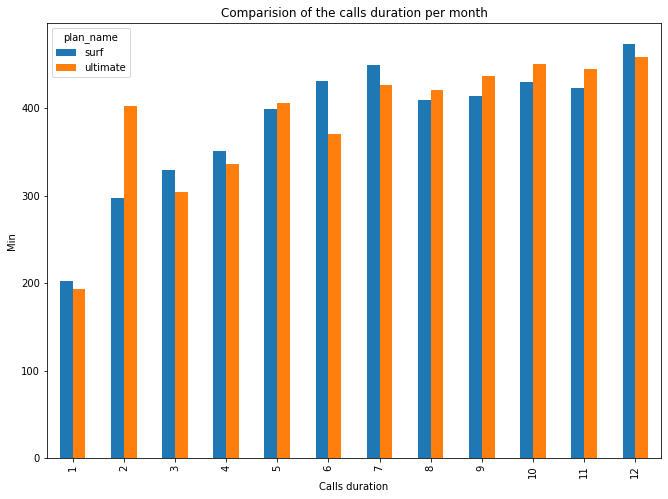

In [32]:
# Compare average duration of calls per each plan per each distinct month. Plot a bar plat to visualize it.
duration_pivot=data.pivot_table(index='plan_name', columns='month', values='calls_dur', aggfunc='mean')
duration_pivot.T.plot(figsize=(11, 8), kind='bar')
plt.title('Comparision of the calls duration per month')
plt.ylabel('Min')
plt.xlabel('Calls duration')

<AxesSubplot:xlabel='calls_dur', ylabel='Count'>

<AxesSubplot:xlabel='calls_dur', ylabel='Count'>

Text(0.5, 0, 'Duration of calls')

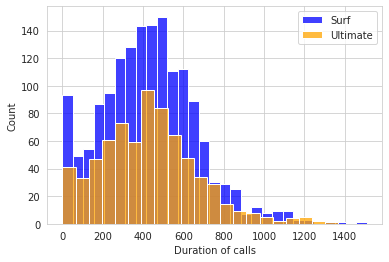

In [33]:
# Compare the number of minutes users of each plan require each month. Plot a histogram.
#Dividing data into 2 groups for each plan
data_surf = data.query('plan_name == "surf"').reset_index()
data_ultimate = data.query('plan_name == "ultimate"').reset_index()

#Plotting histograms
sns.set_style("whitegrid")
sns.histplot(data = data_surf['calls_dur'], label = 'Surf', color = 'blue')
sns.histplot(data= data_ultimate['calls_dur'], label = 'Ultimate', color = 'orange')
plt.legend()
plt.xlabel('Duration of calls')

Obivously, there are more users of the "surf" plan and the mean for both plans is about 400 minures.

Calculating the mean and the variable of the call duration to see that users on the different plans have different behaviours for their calls:

In [34]:
# Calculate the mean of the monthly call duration and the variance of the monthly call duration
df_surf=data[data['plan_name']=='surf']
df_ultimate=data[data['plan_name']=='ultimate']
print ('The mean of the monthly call duration for surf is', np.mean(df_surf['calls_dur']),
       'and the variance of the monthly call duration for surf is', np.var(df_surf['calls_dur']))
print ('The mean of the monthly call duration for ultimate is', np.mean(df_ultimate['calls_dur']),
       'and the variance of the monthly call duration for ultimate is', np.var(df_ultimate['calls_dur']))



The mean of the monthly call duration for surf is 428.7495232040687 and the variance of the monthly call duration for surf is 54933.334591317485
The mean of the monthly call duration for ultimate is 430.45 and the variance of the monthly call duration for ultimate is 57764.12527777777


<Figure size 576x432 with 0 Axes>

<AxesSubplot:ylabel='calls_dur'>

Text(0.5, 1.0, 'Distribution of the monthly call duration surf')

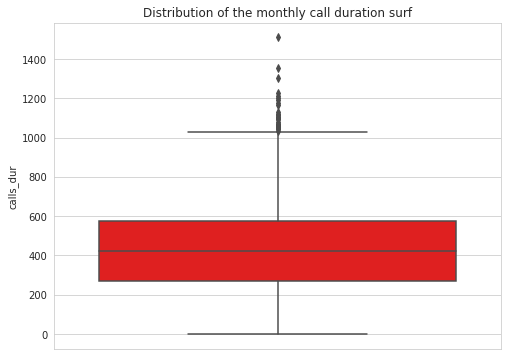

In [35]:
plt.figure(figsize=(8,6))
sns.boxplot(y="calls_dur", data=df_surf,color='red')
plt.title('Distribution of the monthly call duration surf')

<Figure size 576x432 with 0 Axes>

<AxesSubplot:ylabel='calls_dur'>

Text(0.5, 1.0, 'Distribution of the monthly call duration ultimate')

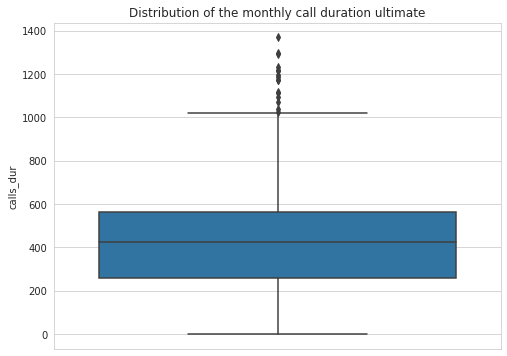

In [36]:
# Plot a boxplot to visualize the distribution of the monthly call duration
plt.figure(figsize=(8,6))
sns.boxplot(y="calls_dur", data=df_ultimate)
plt.title('Distribution of the monthly call duration ultimate')


Conclusion about user's behaviour: let's say that the behaviour is almost the same, both plans have the similar average duration of calls and the variance. Surf plan is much profitable for us, because users pay more for added minutes.

### Messages

<AxesSubplot:xlabel='month'>

Text(0.5, 1.0, 'Mean number of messages per month')

Text(0, 0.5, 'count')

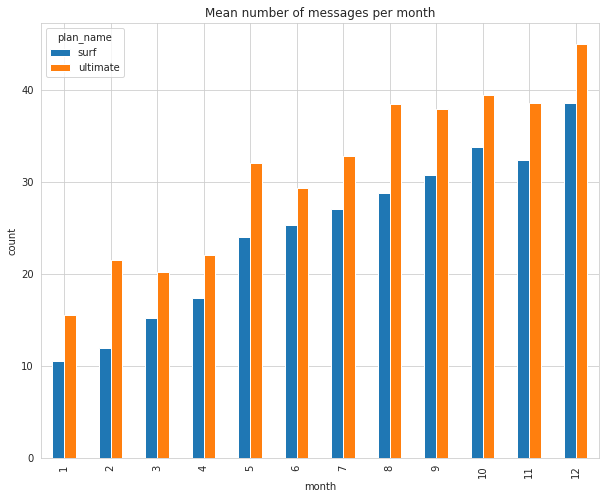

In [37]:
# Compare the average number of messages per each plan per each distinct month. Plot a bar plat to visualize it.
messages_avg =data.pivot_table(index = 'plan_name', columns = 'month', values = 'messages', aggfunc = 'mean')
messages_avg.T.plot(figsize = (10,8), kind = 'bar')
plt.title('Mean number of messages per month')
plt.ylabel('count')


The users behave different between the plans. Ultimate clients use messaging less than surf. 

### Internet

<AxesSubplot:xlabel='mb_used', ylabel='Count'>

Text(0.5, 1.0, 'Comparision of the traffic users of each plan per month')

Text(0.5, 0, 'mb total')

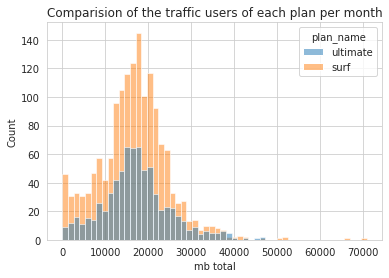

In [38]:
# Compare the amount of internet traffic consumed by users per plan
mb_used=data.groupby(['user_id','month'])['mb_used'].sum()
sns.histplot(data, x='mb_used', hue='plan_name')
plt.title('Comparision of the traffic users of each plan per month')
plt.xlabel('mb total')


The users behave different between the plans. Ultimate clients consume the internet traffic less than surf.

## Revenue

Now let's statistically describe the revenue between the plans.

<AxesSubplot:xlabel='month'>

Text(0.5, 1.0, 'Mean revenue per month')

Text(0, 0.5, 'usd')

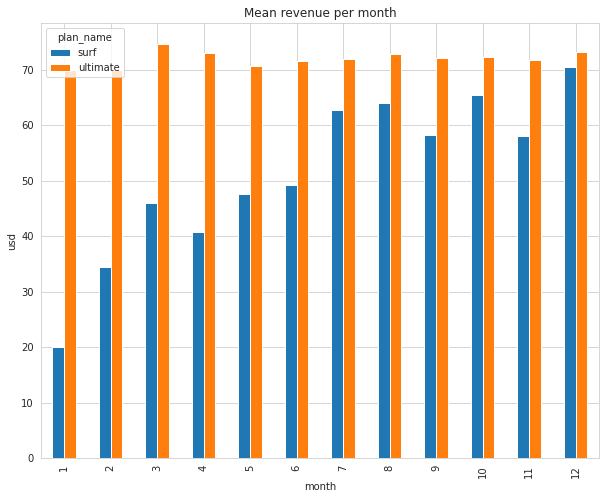

In [39]:
# Compare the monthly revenue per each plan per each distinct month. Plot a bar plat to visualize it.
revenue_avg =data.pivot_table(index = 'plan_name', columns = 'month', values = 'revenue_month', aggfunc = 'mean')
revenue_avg.T.plot(figsize = (10,8), kind = 'bar')
plt.title('Mean revenue per month')
plt.ylabel('usd')



In [40]:
# Calculate the mean and the variance of the monthly revenue
print('Mean revenue per month for Surf plan is', np.mean(data_surf['revenue_month']), 
      'Variance is', np.var(data_surf['revenue_month']))
print('Mean revenue per month for Ultimate plan is', np.mean(data_ultimate['revenue_month']), 
      'Variance is', np.var(data_ultimate['revenue_month']))


Mean revenue per month for Surf plan is 60.706408137317226 Variance is 3065.8848438690247
Mean revenue per month for Ultimate plan is 72.31388888888888 Variance is 129.66814043209877


<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 1.0, 'Surf')

Text(0.5, 1.0, 'Ultimate')

Text(0.0, 0.5, 'Monthly revenue, usd')

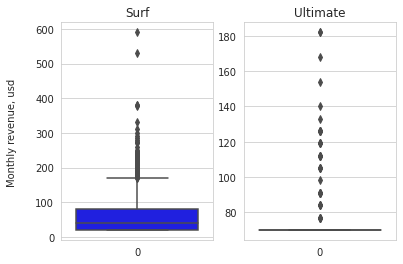

In [41]:
# Plot a boxplot to visualize the distribution of the monthly revenue

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
sns.boxplot(data=data_surf['revenue_month'], color='blue',ax=ax1)
sns.boxplot(data=data_ultimate['revenue_month'], color='orange',ax=ax2)
ax1.set_title('Surf')
ax2.set_title('Ultimate')
fig.text(0.0, 0.5, 'Monthly revenue, usd', va='center', rotation='vertical')

The revenue differs between the plans. Ultimate plan max revenue is equal to it's initial price of 70 usd, no additional sales.
The surf plan is more profitable.

## Test statistical hypotheses

At the end let's check the hypothesis that the average revenue from users of the Ultimate and Surf calling plans differs. Our hypotheses will be formulated with H0(null hypothesis) and H1(alternative hypothesis).
H0: Average monthly revenue from Surf and Ultimate calling plans is equal
H1: Average monthly revenue from Ultimate calling plan is bigger than Surf.
Alpha value of statistical significance: 0.05

Statistical test: Student's test.

In [42]:
# Test the hypotheses

# Test null hypothesis
alpha = 0.05  
results = st.ttest_ind(data_surf['revenue_month'], data_ultimate['revenue_month'], equal_var=False)
print('p-value: ', results.pvalue)

if results.pvalue < alpha:
    print("We reject the null hypothesis. Revenue from Surf and Ultimate plans differ from each other")
else:
    print("We can't reject the null hypothesis")

# Test alternative hypothesis
alpha = 0.05  
results = st.ttest_ind(data_surf['revenue_month'], data_ultimate['revenue_month'], 
                       equal_var=False, alternative = 'greater')
print('p-value: ', results.pvalue)

if results.pvalue < alpha:
    print("We reject the alternative hypothesis.\
Revenue from Surf plan is supposed to be larger than from Ultimate plan")
else:
    print("We can't reject the alternative hypothesis.\
Revenue from Ultimate plan is supposed to be larger than from Surf plan")


p-value:  3.17039054811355e-15
We reject the null hypothesis. Revenue from Surf and Ultimate plans differ from each other
p-value:  0.9999999999999984
We can't reject the alternative hypothesis.Revenue from Ultimate plan is supposed to be larger than from Surf plan


And now let's check the hypothesis that the average revenue from users in the NY-NJ area is different from that of the users from the other regions. Our hypotheses will be formulated with H0(null hypothesis) and H1(alternative hypothesis). 
H0: Average monthly revenue from users in the NY-NJ area differs to that of the users from the other regions
H1: Average monthly revenue from users from the other regions is bigger than that from users in the NY-NJ area . 
Alpha value of statistical significance: 0.05

Statistical test: Student's test.

In [43]:

#Look for unique values of regions we have in our data 
data['region'].unique()

#Creating data_ny_nj DataFrame
data_ny_nj = data[data.region.apply(lambda x: "NY" in x or "NJ" in x or 
                                    "NY-" in x or "NJ-" in x or "-NY" in x or "-NJ" in x)]                      
#Check values and number of rows
data_ny_nj['region'].unique()
data_ny_nj.shape[0]

#Creating data_rest DataFrame from other regions
data_rest = data[data.region.apply(lambda x: "NY" not in x and "NJ" not in x and 
                                    "NY-" not in x and "NJ-" not in x and "-NY" not in x and "-NJ" not in x)]  
#Check number of rows
data_rest.shape[0]

#Check that lenth of 2 DataFrames is equal to full data.
data.shape[0] == data_ny_nj.shape[0] + data_rest.shape[0]

array([' GA MSA', ' WA MSA', ' NV MSA', ' OK MSA', ' TX MSA', ' CA MSA',
       ' MI MSA', ' FL MSA', ' OH MSA', ' IL-IN-WI MSA', ' TN MSA',
       ' NY-NJ-PA MSA', ' PA MSA', ' DC-VA-MD-WV MSA', ' IN MSA',
       ' NE-IA MSA', ' PA-NJ-DE-MD MSA', ' AL MSA', ' NC-SC MSA',
       ' CO MSA', ' NM MSA', ' MA-NH MSA', ' AZ MSA', ' OR-WA MSA',
       ' OH-KY-IN MSA', ' SC MSA', ' NY MSA', ' TN-MS-AR MSA',
       ' KY-IN MSA', ' RI-MA MSA', ' HI MSA', ' CT MSA', ' LA MSA',
       ' VA-NC MSA', ' MD MSA', ' WI MSA', ' VA MSA', ' MO-IL MSA',
       ' MN-WI MSA', ' MO-KS MSA', ' NC MSA', ' UT MSA'], dtype=object)

array([' NY-NJ-PA MSA', ' PA-NJ-DE-MD MSA', ' NY MSA'], dtype=object)

488

1805

True

In [44]:
# Test the hypotheses
# Test null hypothesis
alpha = 0.05  
results = st.ttest_ind(data_ny_nj['revenue_month'], data_rest['revenue_month'], equal_var=False)
print('p-value: ', results.pvalue)

if results.pvalue < alpha:
    print("We reject the null hypothesis. Revenue from users of NY-NJ area differs from other users")
else:
    print("We can't reject the null hypothesis There is a probability that revenue from users of NY-NJ area is \
the same\nas from users of other regions")

p-value:  0.10667494170371572
We can't reject the null hypothesis There is a probability that revenue from users of NY-NJ area is the same
as from users of other regions


So our test has shown us that there is 10% probability, which is more than our level of statistical significance, that revenue from users of NY-NJ area is the same as the revenue from users of other regions. Let's check means and variances.

In [45]:
# Calculate the mean and the variance of the monthly revenue of users from different regions
print('Mean revenue per month for users of NY-NJ region is', np.mean(data_ny_nj['revenue_month']), 
      'Variance is', np.var(data_ny_nj['revenue_month']))
print('Mean revenue per month for other users is', np.mean(data_rest['revenue_month']), 
      'Variance is', np.var(data_rest['revenue_month']))

Mean revenue per month for users of NY-NJ region is 61.35934426229508 Variance is 2105.8745274388607
Mean revenue per month for other users is 65.16001108033241 Variance is 2187.994397562204


In [46]:
# Test null hypothesis
alpha = 0.05  
results = st.ttest_ind(data_ny_nj['revenue_month'], data_rest['revenue_month'], equal_var=True)
print('p-value: ', results.pvalue)

if results.pvalue < alpha:
    print("We reject the null hypothesis. Revenue from users of NY-NJ area differs from other users")
else:
    print("We can't reject the null hypothesis There is a probability that revenue from users of NY-NJ\
 area\nis the same as from users of other regions")

p-value:  0.11013307329186486
We can't reject the null hypothesis There is a probability that revenue from users of NY-NJ area
is the same as from users of other regions


## General conclusion

We started the research with transforming some data in users, calls, messaging, internet traffic data sets. We added some coluns usefull for further investigation.There are more users of the "surf" plan than "ultimate". In calls the mean for both plans is about 400, so ultimate users overpay. The Ultimate plan has 3000  minutes included. Further statistical research shows that customers are more profitable for the company because they often go over the limits and overpay for additional services.The other important conclusion: we splited data into 2 region groups, one for NY-NJ region and the other one for the rest in order to test our second Hypothesis.
The average revenue from users in NY-NJ area is different from that of the users from other regions and brings more revenue.
We formulated our null hypothesis that Average monthly revenue from users of NY-NJ area is the same as average monthly revenue from other users but we couldn't reject it. Our test has shown us that there is 10% probability, that revenue from users of NY-NJ area is the same as the revenue from users of other regions. After we have checked means and variancies for theese groups and performed test one mor time with paameter equal variance set to True, we can make the conclusion, that the second hypothesis is completely incorrect. There is a big probability that revenue from the NY-NJ does not differ from other regions.